In [1]:
from flax import nnx
import jax
from jax import numpy as jnp
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import cm
import optax

In [2]:
def lorenz(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Generate a Lorenz trajectory.
t = np.linspace(0, 40, 20_000)  # 10,000 time steps
initial_state = [1.0, 1.0, 1.0]
trajectory = odeint(lorenz, initial_state, t)  # shape: (10000, 3)

x_length = 100 
y_length = 500
X_list = []
y_list = []
for i in range(len(trajectory) - x_length - y_length):
    X_list.append(trajectory[i:i+x_length])
    y_list.append(trajectory[i+x_length:i+x_length+y_length])
X = np.array(X_list)  # shape: (num_samples, 50, 3)
X = X.reshape(X.shape[0], -1)
y = np.array(y_list)  # shape: (num_samples, 3)
y = y.reshape(X.shape[0], -1)

# Convert the dataset to JAX arrays.
X_jax = jnp.array(X)
y_jax = jnp.array(y)

x_train = X_jax[:10_000]
y_train = y_jax[:10_000]

x_test = X_jax[10_000:]
y_test = y_jax[10_000:]

In [3]:
class twolayerNN(nnx.Module):
    
    def __init__(self, indim, outdim, hdim, rngs: nnx.Rngs):
        
        self.linear1 = nnx.Linear(indim, hdim, rngs=rngs)
        self.linear2 = nnx.Linear(hdim, hdim, rngs=rngs)
        self.linear3 = nnx.Linear(hdim, hdim, rngs=rngs)
        self.linear4 = nnx.Linear(hdim, outdim, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.relu(self.linear3(x))
        x = self.linear4(x)
        return x
    
model = twolayerNN(x_length*3, y_length*3, 100, rngs=nnx.Rngs(0))

In [5]:
model(x_train).shape

(10000, 1500)

In [9]:
learning_rate = 0.001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

In [10]:
def loss_fn(model: twolayerNN, x, y):
  y_pred = model(x)
  return optax.l2_loss(y_pred, y).mean()

@nnx.jit
def train_step(model: twolayerNN, optimizer: nnx.Optimizer, x, y):
  """Train for a single step."""
  grad_fn = nnx.grad(loss_fn)
  grads = grad_fn(model, x, y)
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: twolayerNN, metrics: nnx.MultiMetric, x, y):
  loss = loss_fn(model, x, y)
  metrics.update(loss=loss)  # In-place updates.
  return loss

In [17]:
for epoch in range(500):
    
    # for batch in range(100):
    # Randomly sample a batch of data.
    idx = np.random.choice(x_train.shape[0], 1000, replace=False)
    train_step(model, optimizer, x_train[idx], y_train[idx])
    
    # if epoch % 10 == 0:
    print(f"Step {epoch}, Loss: {eval_step(model, metrics, x_train[idx], y_train[idx])}")

Step 0, Loss: 0.030907396227121353
Step 1, Loss: 0.02372613549232483
Step 2, Loss: 0.022347189486026764
Step 3, Loss: 0.029710400849580765
Step 4, Loss: 0.027622390538454056
Step 5, Loss: 0.024193616583943367
Step 6, Loss: 0.024499429389834404
Step 7, Loss: 0.025149565190076828
Step 8, Loss: 0.024110781028866768
Step 9, Loss: 0.02415432035923004
Step 10, Loss: 0.024679219350218773
Step 11, Loss: 0.02210403047502041
Step 12, Loss: 0.020640164613723755
Step 13, Loss: 0.02394680678844452
Step 14, Loss: 0.024461379274725914
Step 15, Loss: 0.020740142092108727
Step 16, Loss: 0.02249797061085701
Step 17, Loss: 0.01843009702861309
Step 18, Loss: 0.01935592293739319
Step 19, Loss: 0.020980723202228546
Step 20, Loss: 0.018932340666651726
Step 21, Loss: 0.02126966044306755
Step 22, Loss: 0.02155018411576748
Step 23, Loss: 0.02239130437374115
Step 24, Loss: 0.023350002244114876
Step 25, Loss: 0.02102622576057911
Step 26, Loss: 0.019250566139817238
Step 27, Loss: 0.018843302503228188
Step 28, Loss

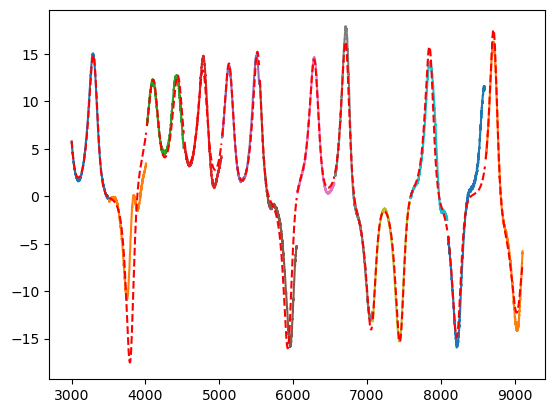

In [14]:
for n in range(3000, 9000, y_length+10):
    xx = np.arange(n, y_length+n)
    yy = model(x_test[n])[::3]
    plt.plot(xx, yy)
    plt.plot(xx, y_test[n][::3], 'r--')



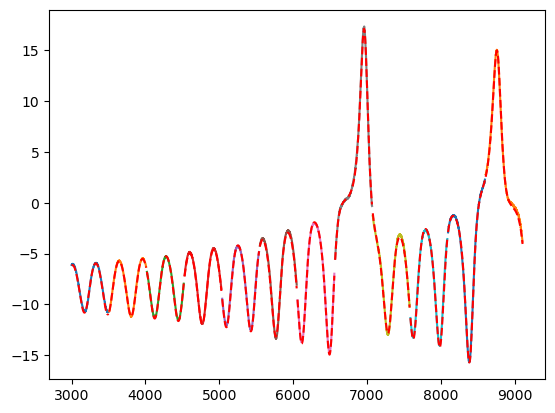

In [8]:
for n in range(3000, 9000, y_length+10):
    xx = np.arange(n, y_length+n)
    yy = model(x_train[n])[::3]
    plt.plot(xx, yy)
    plt.plot(xx, y_train[n][::3], 'r--')



In [104]:
xx.shape

(500,)

In [ ]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(xs, lw=0.5)

for n in range(50):
    # select a random history→future pair
    ioffset = np.random.randint(0, len(xs) - seq_len - pred_len)
    x_hist = jnp.array(xs[ioffset:ioffset+seq_len])
    y_pred = np.array(rnn_forward(params, x_hist))
    ax.plot(np.arange(ioffset, seq_len+ioffset), x_hist,  lw=1, color='blue')
    ax.plot(np.arange(seq_len+ioffset, seq_len+pred_len+ioffset), y_pred,  lw=2, color='orange')

for n, ioffset in enumerate(ioffsets):
    x_hist = jnp.array(xs[ioffset:ioffset+seq_len])
    y_pred = np.array(rnn_forward(params, x_hist))
    ax.plot(np.arange(ioffset, seq_len+ioffset), x_hist,  lw=1, color='blue')
    color = n/len(ioffsets)
    ax.plot(np.arange(seq_len+ioffset, seq_len+pred_len+ioffset), y_pred,  lw=2, color=str(color))

ax.plot(np.arange(seq_len+ioffset, seq_len+pred_len+ioffset), y_pred,  lw=2, color='red')

ax.grid(True)
ax.set_xlabel("Time step")
ax.set_ylabel("Lorenz x-value")
fig.show()    

In [37]:
optimizer.opt_state


(ScaleByAdamState(count=OptArray(
   value=Array(21000, dtype=int32)
 ), mu=State({
   'linear1': {
     'bias': OptVariable(
       source_type=<class 'flax.nnx.variablelib.Param'>,
       value=Array([ 7.61483014e-02,  7.03245774e-02,  4.85297367e-02, -1.74265006e-03,
               2.26638913e-02,  2.40010135e-02, -9.23060700e-02,  7.57624977e-04,
              -7.95566663e-02,  7.29784220e-02,  5.24261110e-02, -3.73970196e-02,
              -5.93019091e-03, -9.13063355e-04,  1.27834687e-02, -4.40453961e-02,
              -1.15759326e-02, -3.50279845e-02, -7.58303140e-05,  3.81582752e-02,
              -1.20111192e-02,  1.12387195e-01, -1.85626708e-02,  5.46097234e-02,
               3.24494168e-02,  8.57974682e-03,  1.57870967e-02, -1.33688765e-04,
               7.31851324e-05, -2.04613712e-02,  1.07083535e-02, -1.70836672e-02,
               2.27511432e-02, -4.37058844e-02,  0.00000000e+00, -8.46923515e-03,
              -6.89003766e-02,  6.59091249e-02, -9.65768122e-05,  2.74081

In [120]:
nnx.nn.recurrent.LSTMCell?

Init signature: nnx.nn.recurrent.LSTMCell(*args: 'Any', **kwargs: 'Any') -> 'Any'
Docstring:     
LSTM cell.

The mathematical definition of the cell is as follows

.. math::
    \begin{array}{ll}
    i = \sigma(W_{ii} x + W_{hi} h + b_{hi}) \\
    f = \sigma(W_{if} x + W_{hf} h + b_{hf}) \\
    g = \tanh(W_{ig} x + W_{hg} h + b_{hg}) \\
    o = \sigma(W_{io} x + W_{ho} h + b_{ho}) \\
    c' = f * c + i * g \\
    h' = o * \tanh(c') \\
    \end{array}

where x is the input, h is the output of the previous time step, and c is
the memory.
File:           ~/miniconda3/envs/seahorce/lib/python3.11/site-packages/flax/nnx/nn/recurrent.py
Type:           ModuleMeta
Subclasses:     